In [6]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

import shap
from sklearn.model_selection import train_test_split


In [ ]:
# Load the Best Trained Models 
print("Loading trained LightGBM pipelines")
# Use os.path.join for robust paths
models_dir = '../models/'
pipeline_ecom = joblib.load(os.path.join(models_dir, 'e-commerce_lightgbm.joblib'))
pipeline_credit = joblib.load(os.path.join(models_dir, 'credit_card_lightgbm.joblib'))
print("Models loaded successfully.")

--- Loading trained LightGBM pipelines ---
Models loaded successfully.


In [ ]:
# Recreate the EXACT Test Data for Explanation

# Load and prepare e-commerce data
fraud_df = pd.read_csv('../data/01_raw/Fraud_Data.csv')
fraud_df.drop_duplicates(inplace=True)
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()
fraud_df_model = fraud_df.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)
X_ecom = fraud_df_model.drop('class', axis=1)
y_ecom = fraud_df_model['class']
X_train_ecom, X_test_ecom, y_train_ecom, y_test_ecom = train_test_split(X_ecom, y_ecom, test_size=0.2, random_state=42, stratify=y_ecom)

# Load and prepare credit card data
credit_df = pd.read_csv('../data/01_raw/creditcard.csv')
credit_df.drop_duplicates(inplace=True)
X_credit = credit_df.drop('Class', axis=1)
y_credit = credit_df['Class']
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit)

print("\nTest data recreated successfully.")


Test data recreated successfully.


Extracting components from the e-commerce pipeline...
Transforming the e-commerce test data...
Creating SHAP TreeExplainer...
Calculating SHAP values... (This may take a moment)


d:\Documents\Projects\10 Academy\week-8\venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


SHAP values calculated.

--- Generating SHAP Summary Plot (E-commerce) ---
Summary plot saved to: ../reports/figures\shap_summary_ecommerce.png


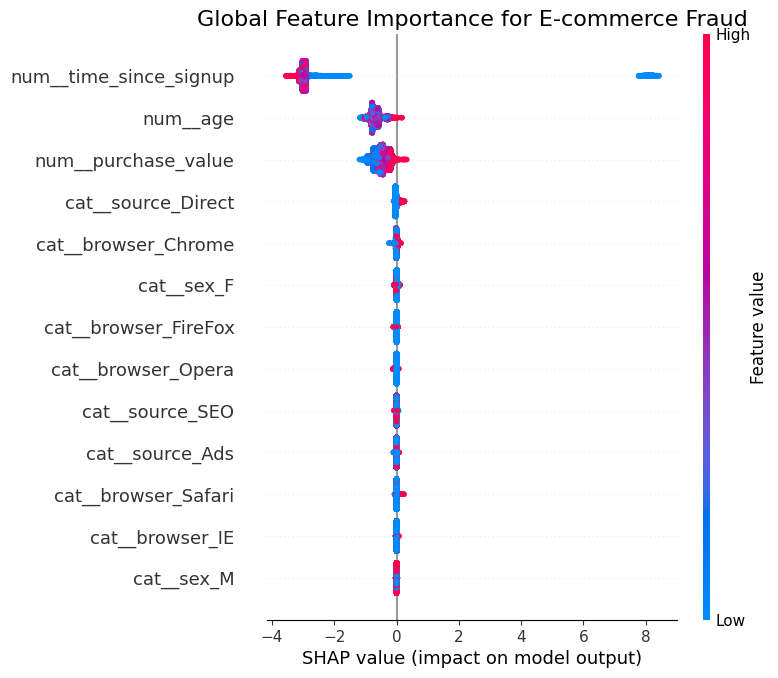


--- Generating SHAP Force Plot for a single True Positive Fraud case (index: 29) ---


d:\Documents\Projects\10 Academy\week-8\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [13]:
# Explain the E-commerce LightGBM Model 

# 1. Extract the individual components from the saved pipeline
print("Extracting components from the e-commerce pipeline...")
preprocessor_ecom = pipeline_ecom.named_steps['preprocessor']
model_ecom = pipeline_ecom.named_steps['classifier']

# 2. Transform the test data using the pipeline's preprocessor
print("Transforming the e-commerce test data...")
X_test_ecom_transformed = preprocessor_ecom.transform(X_test_ecom)

# Get the feature names AFTER transformation for readable plots
feature_names_ecom = preprocessor_ecom.get_feature_names_out()

# For easier use with SHAP, convert the transformed data back to a pandas DataFrame
X_test_ecom_transformed_df = pd.DataFrame(
    X_test_ecom_transformed, 
    columns=feature_names_ecom
)

# 3. Create a SHAP "Explainer" object
print("Creating SHAP TreeExplainer...")
explainer_ecom = shap.TreeExplainer(model_ecom)

# 4. Calculate the SHAP values for every prediction on the test set
print("Calculating SHAP values... (This may take a moment)")
# We get two sets of SHAP values, one for class 0 and one for class 1.
shap_values_ecom = explainer_ecom.shap_values(X_test_ecom_transformed_df)
print("SHAP values calculated.")


# 5. Generate and Interpret SHAP Plots

# A. SHAP Summary Plot (Global Feature Importance)
print("\n--- Generating SHAP Summary Plot (E-commerce) ---")
shap.summary_plot(
    shap_values_ecom,  # Use the SHAP values for the "Fraud" class
    X_test_ecom_transformed_df,
    show=False 
)
plt.title("Global Feature Importance for E-commerce Fraud", fontsize=16)
# 1. Define the output directory and create it
output_dir = '../reports/figures'
os.makedirs(output_dir, exist_ok=True)
# 2. Create the full path for the file
plot_filename = 'shap_summary_ecommerce.png'
full_path = os.path.join(output_dir, plot_filename)
# 3. Save the current figure
plt.savefig(full_path, dpi=300, bbox_inches='tight')
print(f"Summary plot saved to: {full_path}")
plt.show()


# B. SHAP Force Plot (Local Explanation for a Single Prediction)
# Initialize Javascript for interactive plots in the notebook
shap.initjs()

# First, let's find a fraudulent transaction that the model correctly identified (a True Positive)
y_pred_ecom = pipeline_ecom.predict(X_test_ecom)
true_positives_idx = np.where((y_pred_ecom == 1) & (y_test_ecom == 1))[0]

if len(true_positives_idx) > 0:
    # Pick the first true positive case we found
    idx_to_explain = true_positives_idx[0]
    print(f"\n--- Generating SHAP Force Plot for a single True Positive Fraud case (index: {idx_to_explain}) ---")

    # The force plot shows the push-and-pull of each feature for this one prediction
    display(shap.force_plot(
        explainer_ecom.expected_value,              # The model's average prediction
        shap_values_ecom[idx_to_explain, :],        # SHAP values for this specific prediction
        X_test_ecom_transformed_df.iloc[idx_to_explain, :] # The feature values for this prediction
    ))
else:
    print("\nNo True Positives found in the test set to explain with a force plot.")

Extracting components from the credit card pipeline...
Transforming the credit card test data...
Creating SHAP TreeExplainer...
Calculating SHAP values for the credit card model... (This may take a moment)


d:\Documents\Projects\10 Academy\week-8\venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


SHAP values calculated.

--- Generating SHAP Summary Plot (Credit Card) ---
Summary plot saved to: ../reports/figures\shap_summary_creditcard.png


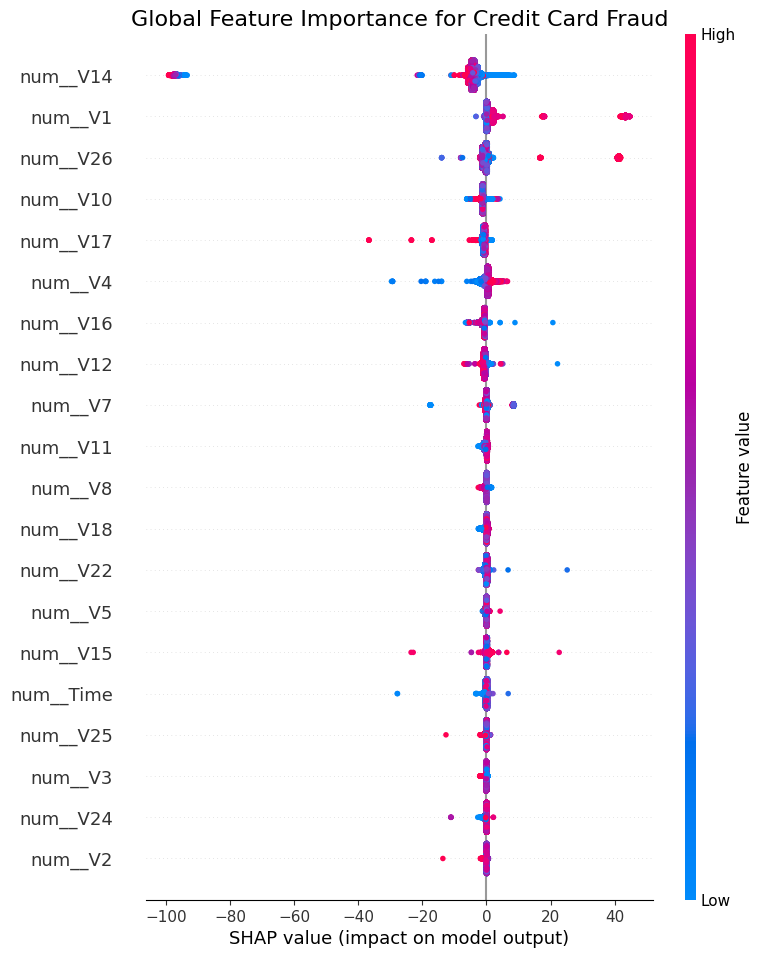


--- Generating SHAP Force Plot for a single True Positive Fraud case (index: 845) ---


d:\Documents\Projects\10 Academy\week-8\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [14]:
# Explain the Credit Card LightGBM Model 

# 1. Extract components from the credit card pipeline
print("Extracting components from the credit card pipeline...")
preprocessor_credit = pipeline_credit.named_steps['preprocessor']
model_credit = pipeline_credit.named_steps['classifier']

# 2. Transform the credit card test data
print("Transforming the credit card test data...")
X_test_credit_transformed = preprocessor_credit.transform(X_test_credit)
feature_names_credit = preprocessor_credit.get_feature_names_out()

# Create a DataFrame for SHAP analysis
X_test_credit_transformed_df = pd.DataFrame(X_test_credit_transformed, columns=feature_names_credit)

# 3. Create a SHAP explainer for the credit card model
print("Creating SHAP TreeExplainer...")
explainer_credit = shap.TreeExplainer(model_credit)

# 4. Calculate SHAP values for the credit card test data
print("Calculating SHAP values for the credit card model... (This may take a moment)")
shap_values_credit = explainer_credit.shap_values(X_test_credit_transformed_df)
print("SHAP values calculated.")


#5. Generate and Interpret SHAP Plots 
# A. SHAP Summary Plot (Global Feature Importance)
print("\n--- Generating SHAP Summary Plot (Credit Card) ---")
shap.summary_plot(
    shap_values_credit,  # Pass the entire shap_values object
    X_test_credit_transformed_df,
    show=False
)
plt.title("Global Feature Importance for Credit Card Fraud", fontsize=16)
# 1. Define the output directory (should already exist)
output_dir = '../reports/figures'
# 2. Create the full path for the file
plot_filename = 'shap_summary_creditcard.png'
full_path = os.path.join(output_dir, plot_filename)
# 3. Save the current figure
plt.savefig(full_path, dpi=300, bbox_inches='tight')
print(f"Summary plot saved to: {full_path}")
plt.show()

# B. SHAP Force Plot (Local Explanation for a Single Prediction)
# Find a correctly identified fraudulent transaction (True Positive)
y_pred_credit = pipeline_credit.predict(X_test_credit)
true_positives_idx_credit = np.where((y_pred_credit == 1) & (y_test_credit == 1))[0]

if len(true_positives_idx_credit) > 0:
    # Pick the first true positive case to explain
    idx_to_explain_credit = true_positives_idx_credit[0]
    print(f"\n--- Generating SHAP Force Plot for a single True Positive Fraud case (index: {idx_to_explain_credit}) ---")

    # Display the force plot for this single prediction
    display(shap.force_plot(
        explainer_credit.expected_value,
        shap_values_credit[idx_to_explain_credit, :],
        X_test_credit_transformed_df.iloc[idx_to_explain_credit, :]
    ))
else:
    print("\nNo True Positives found in the credit card test set to explain with a force plot.")